# Spam Detector Example

This notebook demonstrates a spam detector.

## Setup

Let's import our libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

And some more helper libraries:

In [21]:
from zipfile import ZipFile
from tqdm.notebook import tqdm_notebook as tqdm
import unicodedata

And SciKit algorithms:

In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

Set up our RNG:

In [4]:
rng = np.random.RandomState(20201106)

## Load TREC Spam

Now we're going to load the TREC Spam data set.

I downloaded this data from <https://plg.uwaterloo.ca/~gvcormac/treccorpus07/>, and converted the TGZ file from TREC to a Zip file so that we can read it directly from the compressed file.  This is because each e-mail is in a separate file, all in the same directory; a directory with 75K files does not perform well on sime file systems.  Here is the command I used to convert it (with Node.js installed):

    npx tar-to-zip trec07p.tgz

We're going to start by opening the zip file so we can access its contents:

In [5]:
trec_zf = ZipFile('trec07p.zip')

Now we want to load the labels — these are in the file `trec07p/full/index`.  We'll get a data frame, which contains the class (spam or ham) and the filename:

In [6]:
with trec_zf.open('trec07p/full/index') as idxf:
    trec_labels = pd.read_table(idxf, sep=' ', names=['label', 'path'])
trec_labels.head()

,label,path
0,spam,../data/inmail.1
1,ham,../data/inmail.2
2,spam,../data/inmail.3
3,spam,../data/inmail.4
4,spam,../data/inmail.5


In [7]:
trec_labels.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   75419 non-null  object
 1   path    75419 non-null  object
dtypes: object(2)
memory usage: 9.9 MB


Let's double-check that we don't have any duplicate paths:

In [8]:
trec_labels['path'].nunique()

75419

We can use these filenames to extract the individual messages.  Let's do this:

1. Extract the filename (after the `/`) for use as a key
2. Load each file's contents into a string
3. Merge with labels for a labeled spam/ham data set

Start by replacing everything up to the final `/` with nothing:

In [9]:
trec_labels['name'] = trec_labels['path'].str.replace(r'^.*/', '')
trec_labels.head()

,label,path,name
0,spam,../data/inmail.1,inmail.1
1,ham,../data/inmail.2,inmail.2
2,spam,../data/inmail.3,inmail.3
3,spam,../data/inmail.4,inmail.4
4,spam,../data/inmail.5,inmail.5


Now we're going to load all the mails. No way to get around doing this as a loop - we could do it with `apply`, but that's just a loop.  We'll put it in a dictionary, then convert that to a series; the result is a series indexed by name, whose values are the e-mails.  We're also going to use TQDM to get a progress bar.

While we are loading the data, we will also perform our **decoding** and **text normalization** steps.

In [22]:
trec_mails = {}
for name in tqdm(trec_labels['name']):
    path = f'trec07p/data/{name}'
    with trec_zf.open(path) as mailf:
        content = mailf.read()
        content = content.decode('latin1')
        content = unicodedata.normalize('NFKD', content)
        trec_mails[name] = content
trec_mails = pd.Series(trec_mails, name='content')
len(trec_mails)

75419

Now, we can merge with the labels.  Let's create an `IsSpam` logical to mark the spams, then merge:

In [43]:
trec_labels['IsSpam'] = trec_labels['label'] == 'spam'
trec_data = trec_labels.set_index('name')[['label', 'IsSpam']].join(trec_mails)
trec_data.head()

,label,IsSpam,content
name,,,
inmail.1,spam,True,From RickyAmes@aol.com Sun Apr 8 13:07:32 20...
inmail.2,ham,False,From bounce-debian-mirrors=ktwarwic=speedy.uwa...
inmail.3,spam,True,From 7stocknews@tractionmarketing.com Sun Apr...
inmail.4,spam,True,From vqucsmdfgvsg@ruraltek.com Sun Apr 8 13:...
inmail.5,spam,True,From dcube@totalink.net Sun Apr 8 13:19:30 2...


In [44]:
trec_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 75419 entries, inmail.1 to inmail.75419
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    75419 non-null  object
 1   IsSpam   75419 non-null  bool  
 2   content  75419 non-null  object
dtypes: bool(1), object(2)
memory usage: 622.1 MB


Let's make some train and test data:

In [28]:
trec_test = trec_data.sample(frac=0.2, random_state=rng)
mask = pd.Series(True, index=trec_data.index)
mask[trec_test.index] = False
trec_train = trec_data[mask]

## Exploration

How are spam and ham distributed?

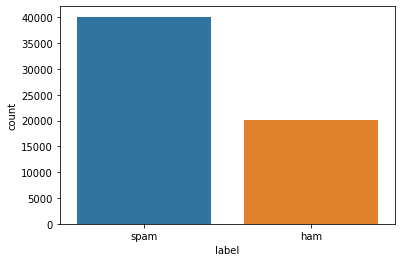

In [31]:
sns.countplot(trec_train['label'])

We have more spams than hams.  What is the fraction?

In [32]:
np.mean(trec_train['IsSpam'])

0.665318637606696

Let's make a majority-class classifier and a randomized classifier (that will return 'Spam' with the probability learned from the data):

In [33]:
maj_class = DummyClassifier(strategy='most_frequent')
rnd_class = DummyClassifier(strategy='stratified', random_state=rng)

Train them and view classification reports on the training data:

In [34]:
maj_class.fit(trec_train['content'], trec_train['label'])
print(classification_report(trec_train['label'], maj_class.predict(trec_train['content'])))

C:\Users\michaelekstrand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ham       0.00      0.00      0.00     20193
        spam       0.67      1.00      0.80     40142

    accuracy                           0.67     60335
   macro avg       0.33      0.50      0.40     60335
weighted avg       0.44      0.67      0.53     60335



In [35]:
rnd_class.fit(trec_train['content'], trec_train['label'])
print(classification_report(trec_train['label'], rnd_class.predict(trec_train['content'])))

              precision    recall  f1-score   support

         ham       0.34      0.34      0.34     20193
        spam       0.67      0.66      0.67     40142

    accuracy                           0.55     60335
   macro avg       0.50      0.50      0.50     60335
weighted avg       0.56      0.55      0.55     60335



## Naive Bayes

Now let's build a real spam filter.

In [36]:
nb_class = Pipeline([
    ('vectorize', CountVectorizer()),
    ('classify', MultinomialNB())
])
nb_class.fit(trec_train['content'], trec_train['label'])

Pipeline(steps=[('vectorize', CountVectorizer(encoding='latin1')),
                ('classify', MultinomialNB())])

How does it do on the training data?

In [37]:
print(classification_report(trec_train['label'], nb_class.predict(trec_train['content'])))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00     20193
        spam       1.00      1.00      1.00     40142

    accuracy                           1.00     60335
   macro avg       1.00      1.00      1.00     60335
weighted avg       1.00      1.00      1.00     60335



That's pretty good :)

## Evaluation

Let's evaluate our classifiers on the test data.

In [38]:
trec_results = trec_test[['label']].copy()
trec_results['Majority'] = maj_class.predict(trec_test['content'])
trec_results['Random'] = rnd_class.predict(trec_test['content'])

In [39]:
trec_results['NaiveBayes'] = nb_class.predict(trec_test['content'])

Let's look at basic metrics for each of our predictors. First majority:

In [40]:
print(classification_report(trec_results['label'], trec_results['Majority']))

              precision    recall  f1-score   support

         ham       0.00      0.00      0.00      5027
        spam       0.67      1.00      0.80     10057

    accuracy                           0.67     15084
   macro avg       0.33      0.50      0.40     15084
weighted avg       0.44      0.67      0.53     15084



C:\Users\michaelekstrand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now random:

In [41]:
print(classification_report(trec_results['label'], trec_results['Random']))

              precision    recall  f1-score   support

         ham       0.33      0.34      0.34      5027
        spam       0.67      0.66      0.67     10057

    accuracy                           0.56     15084
   macro avg       0.50      0.50      0.50     15084
weighted avg       0.56      0.56      0.56     15084



And Naive Bayes:

In [42]:
print(classification_report(trec_results['label'], trec_results['NaiveBayes']))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      5027
        spam       1.00      1.00      1.00     10057

    accuracy                           1.00     15084
   macro avg       1.00      1.00      1.00     15084
weighted avg       1.00      1.00      1.00     15084



The precision for predicting ham is the specificity for predicting spam.  **Think about why that is.**